# Building Concatenated Model

In [1]:
# cd CrisisMMD_Dataset

In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [5]:
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

In [6]:
path = Path('/notebooks/CrisisMMD_Dataset')
# path.ls()

In [7]:
path_img = path/'data_image'

In [8]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [11]:
#reading csv files and doing initial necessary processing
data_human_text_image,test_data_human_text_image = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading already preprocessed data.....


In [12]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(f"train set: {data_human_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")

shape of data: (7124, 10)

train set: 6126
valid set: 998
shape of test data: (955, 9)



In [13]:
MODEL_CLASSES = {'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig)}

In [14]:
model_type = 'xlm'
pretrained_model_name = 'xlm-clm-enfr-1024'

In [15]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [17]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [19]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [20]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [21]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [22]:
# preprocessing and creating databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)

# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [25]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = True
print(config)

XLMConfig {
  "architectures": [
    "XLMWithLMHeadModel"
  ],
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "bos_token_id": 0,
  "causal": false,
  "dropout": 0.1,
  "emb_dim": 1024,
  "embed_init_std": 0.02209708691207961,
  "end_n_top": 5,
  "eos_index": 1,
  "gelu_activation": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "id2lang": {
    "0": "en",
    "1": "fr"
  },
  "init_std": 0.02,
  "is_encoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "lang2id": {
    "en": 0,
    "fr": 1
  },
  "lang_id": 0,
  "layer_norm_eps": 1e-12,
  "mask_index": 5,
  "mask_token_id": 0,
  "max_position_embeddings": 512,
  "max_vocab": -1,
  "min_count": 0,
  "model_type": "xlm",
  "n_heads": 8,
  "n_langs": 2,
  "n_layers": 6,
  "pad_index": 2,
  "pad_token_id": 2,
  "same_enc_dec": true,
  "share_inout_emb": true,
  "sinusoid

In [26]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [27]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [31]:
print(learn_clas.model)

CustomTransformerModel(
  (transformer): XLMForSequenceClassification(
    (transformer): XLMModel(
      (position_embeddings): Embedding(512, 1024)
      (lang_embeddings): Embedding(2, 1024)
      (embeddings): Embedding(64139, 1024, padding_idx=2)
      (layer_norm_emb): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (attentions): ModuleList(
        (0): MultiHeadAttention(
          (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (1): MultiHeadAttention(
          (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (out_lin): Linear(in_features=1

In [32]:
learn_clas.model.transformer=learn_clas.model.transformer.transformer

In [33]:
# learn_clas.model.transformer = learn_clas.model.transformer.roberta
print(learn_clas.model)

CustomTransformerModel(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1024)
    (lang_embeddings): Embedding(2, 1024)
    (embeddings): Embedding(64139, 1024, padding_idx=2)
    (layer_norm_emb): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): MultiHeadAttention(
       

In [35]:
#creating databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_human_text_image,path,224)
test_data_img = get_test_image_data(test_data_human_text_image,path,224)

# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [37]:
# creating a learner object with image model to use it for concatenation 
arch = models.vgg19_bn
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [38]:
# learn_img.model

In [39]:
learn_img.model[-1] = learn_img.model[-1][:-3]
learn_img.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [44]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [47]:
# creating dataloader object of databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [48]:
#creating databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [49]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([32, 3, 224, 224])
Shape text batch: torch.Size([32, 39])
Shape dependent var: torch.Size([32])


In [52]:
lin_layers = [512+1024, 5]
ps = 0.1
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,with_transformer=True)

In [53]:
learn_clas.model

CustomTransformerModel(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1024)
    (lang_embeddings): Embedding(2, 1024)
    (embeddings): Embedding(64139, 1024, padding_idx=2)
    (layer_norm_emb): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): MultiHeadAttention(
       

In [54]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.position_embeddings)+
                                flatten_model(learn_clas.model.transformer.lang_embeddings)+
                                flatten_model(learn_clas.model.transformer.embeddings)+
                                flatten_model(learn_clas.model.transformer.layer_norm_emb)+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.attentions)+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.layer_norm1)+
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(flatten_model(learn_clas.model.transformer.ffns)+
                               flatten_model(learn_clas.model.transformer.layer_norm2)+
                   flatten_model(model.layers)))]

In [55]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [56]:
len(learn.layer_groups)

4

In [57]:
learn.freeze()

In [58]:
# print(learn.summary())

In [59]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 3.98E-03


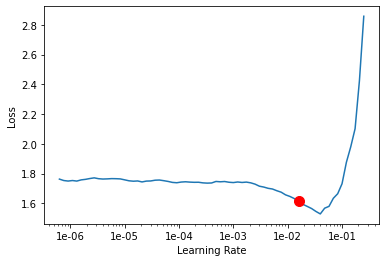

In [60]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.031695,1.108426,0.621242,0.491010,0.674258,0.519932,0.621242,0.484360,0.621973,01:23
1,1.169688,1.073434,0.664329,0.549444,0.712421,0.584636,0.664329,0.547895,0.665171,01:21
2,0.860178,0.824423,0.711423,0.595893,0.735752,0.596385,0.711423,0.568433,0.714335,01:21
3,0.700296,0.697163,0.738477,0.591677,0.737800,0.594877,0.738477,0.591893,0.737646,01:21
4,0.607043,0.702121,0.743487,0.606688,0.746146,0.603304,0.743487,0.597173,0.743486,01:21


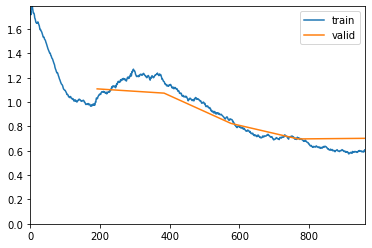

Better model found at epoch 0 with accuracy value: 0.6212424635887146.
Better model found at epoch 1 with accuracy value: 0.6643286347389221.
Better model found at epoch 2 with accuracy value: 0.711422860622406.
Better model found at epoch 3 with accuracy value: 0.7384769320487976.
Better model found at epoch 4 with accuracy value: 0.7434870004653931.


In [61]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-2), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.731242,0.700467,0.761523,0.590343,0.759346,0.569526,0.761523,0.576442,0.756231,01:22
1,0.533133,0.683729,0.758517,0.598662,0.765014,0.603574,0.758517,0.597405,0.759189,01:21


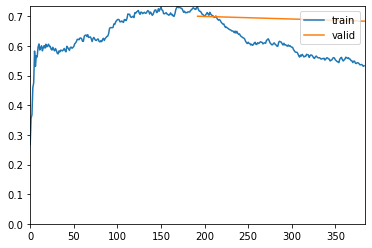

In [62]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.625512,0.812832,0.694389,0.568322,0.709136,0.543702,0.694389,0.543422,0.695250,01:34
1,0.472022,0.675573,0.772545,0.630361,0.769479,0.594621,0.772545,0.610122,0.768989,01:34
2,0.165201,0.665457,0.785571,0.706417,0.782771,0.618774,0.785571,0.636901,0.781727,01:34


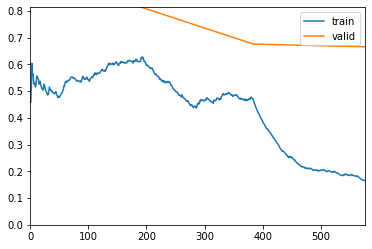

In [63]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


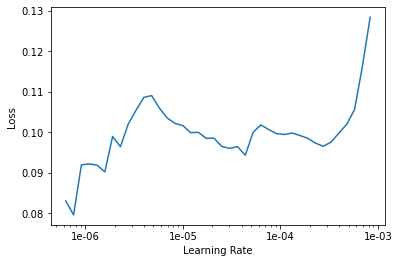

In [64]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.114584,0.749062,0.759519,0.570816,0.760036,0.596074,0.759519,0.581259,0.758846,01:56
1,0.068145,0.768644,0.768537,0.630141,0.765167,0.613848,0.768537,0.618670,0.766200,01:56


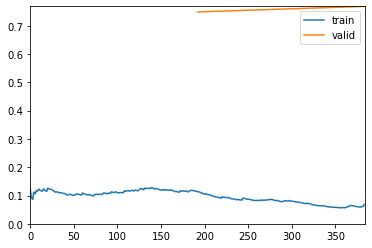

In [65]:
learn.fit_one_cycle(2, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.047618,0.839475,0.752505,0.563282,0.754985,0.603973,0.752505,0.581125,0.751555,01:55
1,0.046383,0.935157,0.766533,0.576043,0.763920,0.605269,0.766533,0.588720,0.764316,01:55
2,0.030049,1.013006,0.757515,0.568922,0.761963,0.601774,0.757515,0.582468,0.757839,01:55
3,0.018019,0.964628,0.776553,0.595108,0.769482,0.597713,0.776553,0.595186,0.771974,01:55


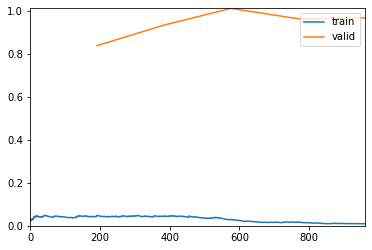

Better model found at epoch 0 with accuracy value: 0.7525050044059753.
Epoch 1: reducing lr to 9.504846320134734e-05
Better model found at epoch 1 with accuracy value: 0.7665330767631531.
Epoch 2: reducing lr to 6.11262021936289e-05
Epoch 3: reducing lr to 1.8825834605023693e-05
Better model found at epoch 3 with accuracy value: 0.7765530943870544.
Epoch 4: early stopping
Better model found at epoch 4 with accuracy value: 0.7785571217536926.


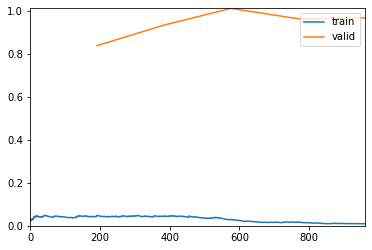

In [66]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [67]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn)

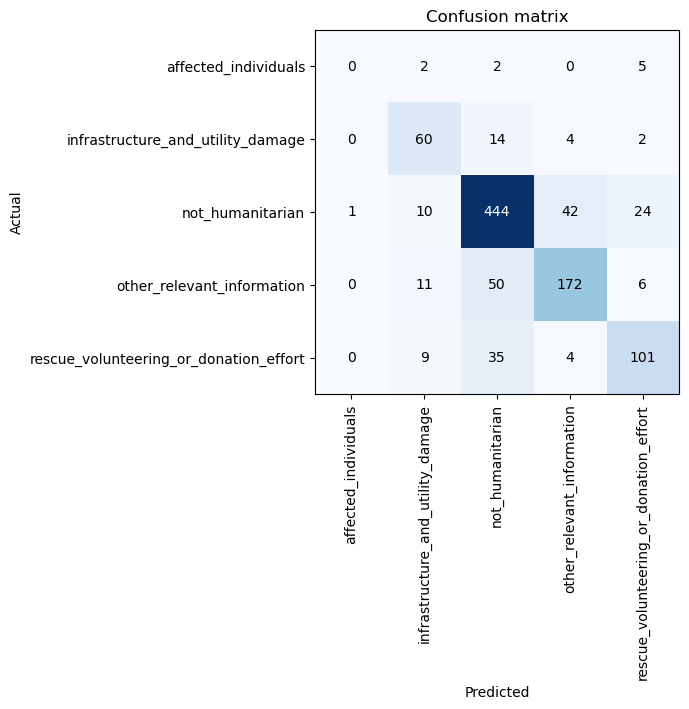

In [68]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [69]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.96818614,
 tensor(0.7786),
 tensor(0.5947),
 tensor(0.7724),
 tensor(0.5999),
 tensor(0.7786),
 tensor(0.5961),
 tensor(0.7746)]

In [70]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.00      0.00      0.00         9
     infrastructure_and_utility_damage       0.65      0.75      0.70        80
                      not_humanitarian       0.81      0.85      0.83       521
            other_relevant_information       0.77      0.72      0.75       239
rescue_volunteering_or_donation_effort       0.73      0.68      0.70       149

                              accuracy                           0.78       998
                             macro avg       0.59      0.60      0.60       998
                          weighted avg       0.77      0.78      0.77       998



In [71]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.8163011,
 tensor(0.8084),
 tensor(0.7694),
 tensor(0.8070),
 tensor(0.6800),
 tensor(0.8084),
 tensor(0.7069),
 tensor(0.8054)]

In [72]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.75      0.33      0.46         9
     infrastructure_and_utility_damage       0.71      0.80      0.76        81
                      not_humanitarian       0.83      0.88      0.85       504
            other_relevant_information       0.86      0.80      0.83       235
rescue_volunteering_or_donation_effort       0.70      0.59      0.64       126

                              accuracy                           0.81       955
                             macro avg       0.77      0.68      0.71       955
                          weighted avg       0.81      0.81      0.81       955

